In [40]:
from pathlib import Path
import json
import xgi
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [41]:
def read_jsonl(fname):
    out=[]
    with open(fname, 'r') as file:
        # Read each line in the file
        for line in file:
            # Parse the JSON string and add the resulting dictionary to the list
            out.append(json.loads(line))
    return out

def flatten(l):
    return [item for sublist in l for item in sublist]


In [42]:
dir_author = Path(".cache_author/")
fnames = list(dir_author.glob("*"))

target_PI = "A5035455593"
# target_PI = "A5071749890"
target_name = 'Laurent Hébert‐Dufresne'
# target_name = 'Alan Hastings'
PI_fnames = [fname for fname in fnames if fname.stem.split("_")[0] == target_PI]
PI_fnames = sorted(PI_fnames, key=lambda p: int(str(p).split('_')[-1].split('.')[0]))
print(f"PI's age: {len(PI_fnames)}")

PI's age: 14


In [43]:
def get_coauths_dict(fnames):
    all_coauths_aid = []
    all_coauths = []
    for fname in fnames:
        all_auth_objects = flatten([_['authorships'] for _ in read_jsonl(fname)])
        all_coauths_aid += [_['author']['id'].split("/")[-1] for _ in all_auth_objects]
        all_coauths += [_['author']['display_name'] for _ in all_auth_objects]
    return {aid:n for aid,n in zip(all_coauths_aid, all_coauths)}

aid2name = get_coauths_dict(PI_fnames)

In [44]:
name2aid={a:n for n,a in aid2name.items()}

In [45]:
works = read_jsonl(PI_fnames[2]) 
print(f"# papers that year: {len(works)}")

# papers that year: 6


In [46]:
authors = works[0]['authorships']

In [47]:
def extract_coauthor(w):
    return [_['author']['display_name'] for _ in w['authorships']]

hyperedge_list = [extract_coauthor(w) for w in works]

In [48]:
def extract_coauthor_inst(works):
    """
    right now we only see collabs' institutions of papers that
    collabs shared with the PI... Ideally we would look at all their work.
    """
    time_collabo = {}  # Reset for each year
    for work in works:
        for a in work['authorships']:
            # a=work['authorships'][1]
            author_name = a['author']['display_name']

            institutions = a['institutions'] if 'institutions' in a else []
            
            # Increment collaboration count for the current year
            author_yearly_data = time_collabo.get(author_name, {'count': 0, 'institutions': {}})
            author_yearly_data['count'] += 1
            
            # Increment institution count for the current year
            for inst in institutions:
                inst_name = inst['display_name']
                author_yearly_data['institutions'][inst_name] = author_yearly_data['institutions'].get(inst_name, 0) + 1
            
            time_collabo[author_name] = author_yearly_data

    return time_collabo

In [49]:
time_collabo=extract_coauthor_inst(works)
time_collabo

{'Antoine Allard': {'count': 6, 'institutions': {'Université Laval': 3}},
 'Laurent Hébert‐Dufresne': {'count': 6,
  'institutions': {'Université Laval': 3}},
 'Pierre-André Noël': {'count': 4, 'institutions': {'Université Laval': 3}},
 'Vincent Marceau': {'count': 4, 'institutions': {'Université Laval': 3}},
 'Louis J. Dubé': {'count': 6, 'institutions': {'Université Laval': 3}},
 'Jean-Gabriel Young': {'count': 1, 'institutions': {'Université Laval': 1}}}

In [50]:
def extract_main_inst(time_collabo, PI_name):
    if len(time_collabo[PI_name]['institutions']) == 0:
        target_institution = None
    else:
        target_institution = max(time_collabo[PI_name]['institutions'], key=time_collabo[PI_name]['institutions'].get)
    out={}
    for author_name, author_data in time_collabo.items():
        shared_inst = None
        max_institution = None
        if author_data['institutions'] and target_institution:
            max_institution = max(author_data['institutions'], key=author_data['institutions'].get)
            if max_institution == target_institution:
                shared_inst = max_institution
        out.update({author_name: {'institution': max_institution, 'is_shared': True if shared_inst else False}})
    return out

node_meta_dict = extract_main_inst(time_collabo, target_name)
node_meta_dict

{'Antoine Allard': {'institution': 'Université Laval', 'is_shared': True},
 'Laurent Hébert‐Dufresne': {'institution': 'Université Laval',
  'is_shared': True},
 'Pierre-André Noël': {'institution': 'Université Laval', 'is_shared': True},
 'Vincent Marceau': {'institution': 'Université Laval', 'is_shared': True},
 'Louis J. Dubé': {'institution': 'Université Laval', 'is_shared': True},
 'Jean-Gabriel Young': {'institution': 'Université Laval', 'is_shared': True}}

In [51]:
hyperedge_list_meta = []
for e in hyperedge_list:
    hyperedge_list_meta.append((e, {'local_work':True if sum([node_meta_dict[a]['is_shared'] for a in e]) > 1 else False}))

In [52]:
set_individuals_involved_local_work = set(flatten([_[0] for _ in hyperedge_list_meta if _[1]['local_work']]))

In [53]:
nodelist = []
for i,auth in enumerate(node_meta_dict.keys()):
    nodelist.append((auth, {
        'institution': node_meta_dict[auth]['institution'], 
        'is_shared': node_meta_dict[auth]['is_shared'],
        'involve_local_work': True if auth in set_individuals_involved_local_work  else False
        }))

In [54]:
H = xgi.Hypergraph()

In [55]:
H.add_nodes_from(nodelist)
H.add_edges_from(hyperedge_list_meta)
print(f"The hypergraph has {H.num_nodes} nodes and {H.num_edges} edges")

The hypergraph has 6 nodes and 6 edges


Highest degree: Antoine Allard


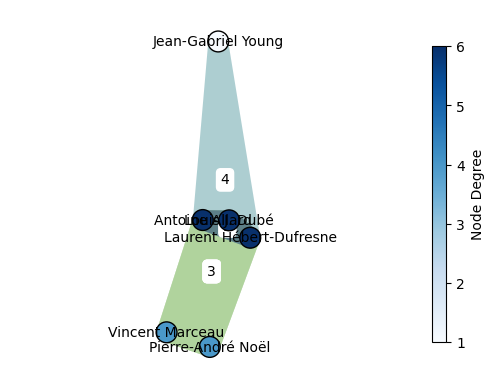

In [56]:
pos = xgi.barycenter_spring_layout(H, seed=42)  # fix position
ax, collections = xgi.draw(H, pos=pos, node_labels=True, node_size=15, node_fc=H.nodes.degree(), node_fc_cmap="Blues", hyperedge_labels=True, hull=True)
(node_collection, _, _) = collections
# print({H.nodes.degree().asdict()})

max_key = max(H.nodes.degree().asdict(), key=H.nodes.degree().asdict().get)
print(f"Highest degree: {max_key}") # highest degree node 
plt.colorbar(node_collection, label="Node Degree", shrink=0.8)

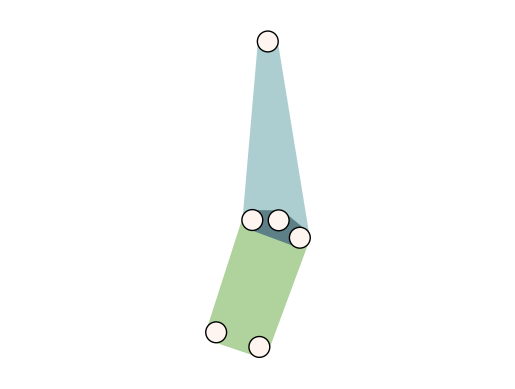

In [57]:
pos = xgi.barycenter_spring_layout(H, seed=42)  # fix position
ax, collections = xgi.draw(
    H, pos=pos, node_size=15, 
    node_fc=H.nodes.attrs("is_shared").aslist(), 
    hull=True)
(node_collection, _, _) = collections

max_key = max(H.nodes.degree().asdict(), key=H.nodes.degree().asdict().get)

In [58]:
H_f = xgi.subhypergraph(
    H, 
    nodes=H.nodes.filterby_attr("involve_local_work", True),
    edges=H.edges.filterby_attr("local_work", True)
)

In [59]:
print(f"{H_f.num_nodes} nodes and {H_f.num_edges} edges")

6 nodes and 6 edges


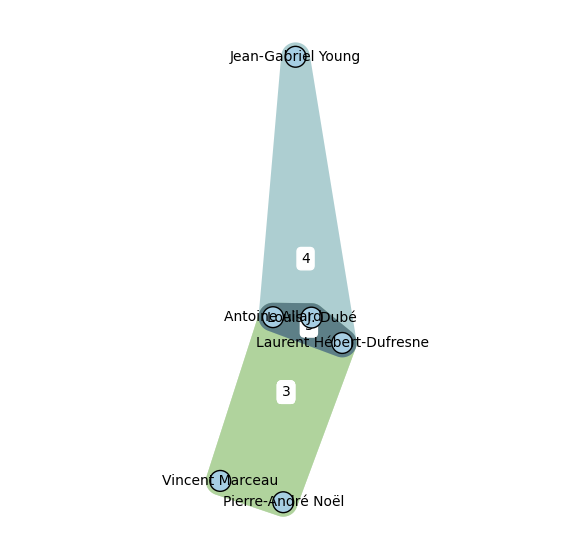

In [64]:
if H_f.num_nodes > 0:
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    pos = xgi.barycenter_spring_layout(H_f, seed=42)  # fix position
    ax, collections = xgi.draw(
        H_f, pos=pos, node_size=15, hyperedge_labels=True,
        node_fc=H_f.nodes.attrs("is_shared").aslist(), 
        node_fc_cmap="Paired", 
        node_labels=True,
        hull=True
        )
    (node_collection, _, _) = collections

    max_key = max(H_f.nodes.degree().asdict(), key=H.nodes.degree().asdict().get)

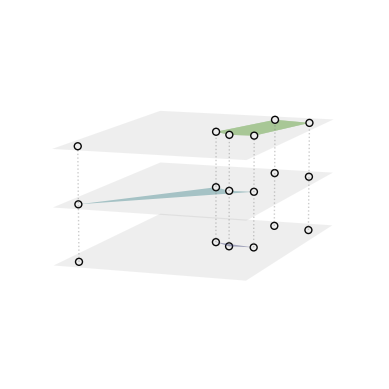

In [65]:
if H_f.num_nodes > 0:
    ax3 = plt.axes(projection="3d")  # requires a 3d axis
    xgi.draw_multilayer(H_f, ax=ax3)

    plt.show()

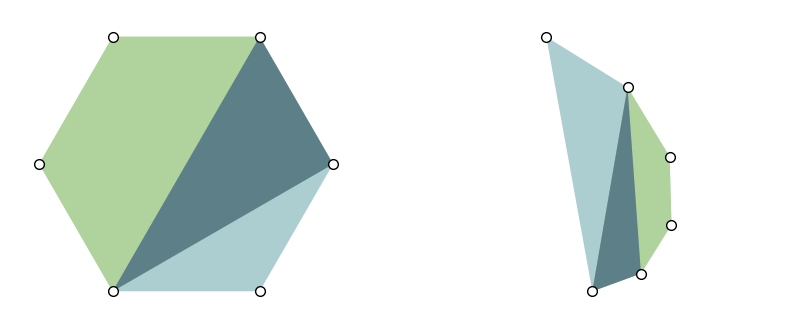

In [66]:
if H_f.num_nodes > 0:
    plt.figure(figsize=(10, 4))

    ax = plt.subplot(1, 2, 1)
    pos_circular = xgi.circular_layout(H_f)
    xgi.draw(H_f, pos=pos_circular, ax=ax,)

    ax = plt.subplot(1, 2, 2)
    pos_spiral = xgi.spiral_layout(H_f)
    xgi.draw(H_f, pos=pos_spiral, ax=ax)

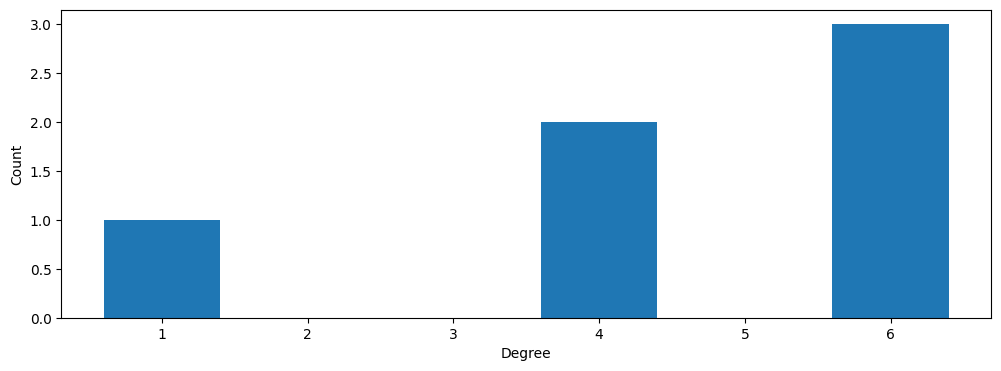

In [67]:
centers, heights = xgi.degree_histogram(H)

plt.figure(figsize=(12, 4))
ax = plt.subplot(111)

ax.bar(centers, heights)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.set_xticks(np.arange(1, max(centers) + 1, step=1));

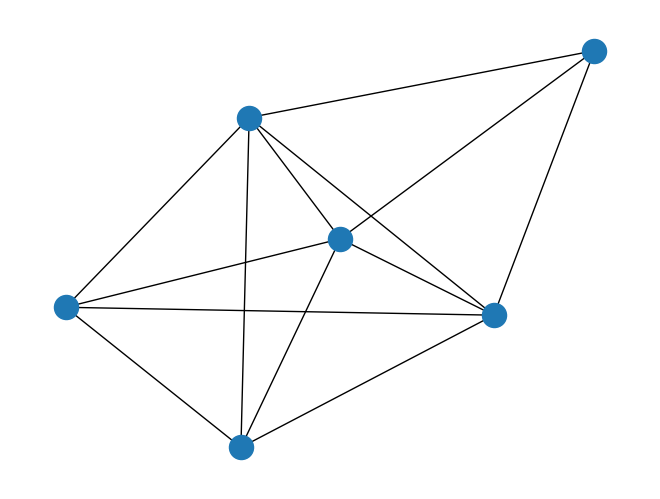

In [68]:
G = xgi.convert.graph.to_graph(H)
nx.draw(G)

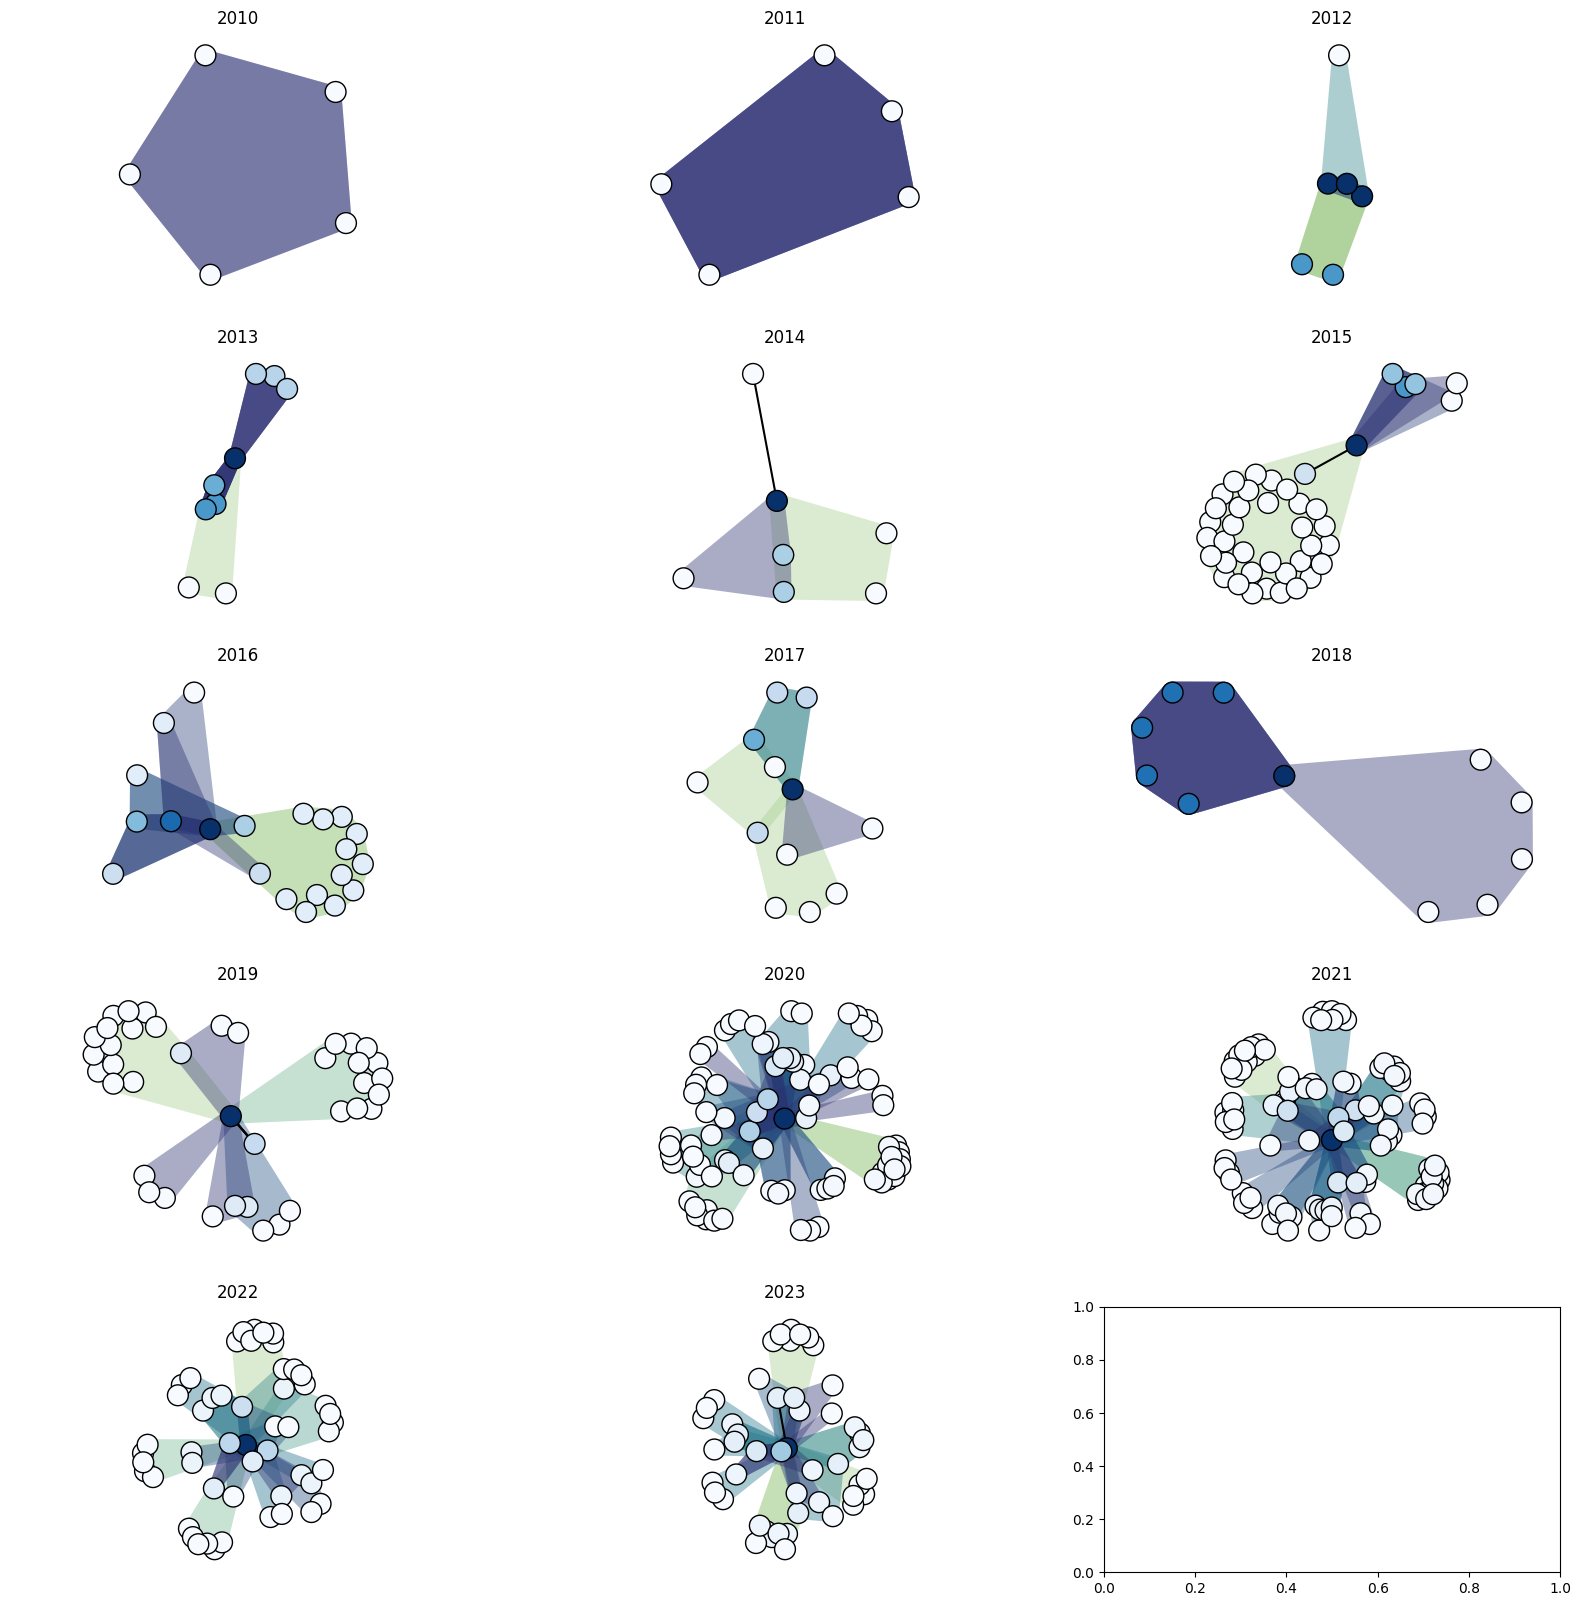

In [69]:
yr_window = 1
tot_yrs = list(range(0, len(PI_fnames)+1, yr_window))
tot_frames = len(tot_yrs)
nb_rows = tot_frames // 3
height_d = { 1:20, 2:15, 3:10 }
fig, axes = plt.subplots(nb_rows, 3, figsize=(20,height_d[yr_window]))

for idx, ax in zip(tot_yrs, axes.flatten()):
    hyperedge_list = []
    for i,fname in enumerate(PI_fnames[idx:(idx+yr_window)]):
        work = read_jsonl(fname)
        if i == 0:
            first_yr=fname.stem.split('_')[-1]
        last_yr=fname.stem.split('_')[-1]
        hyperedge_list += [extract_coauthor(w) for w in work]
    
        
    H = xgi.Hypergraph(hyperedge_list)
    if len(H.nodes) > 0:
        pos = xgi.barycenter_spring_layout(H, seed=42)  # fix position
        _, collections = xgi.draw(H, ax=ax, pos=pos, node_size=15, node_labels=False, node_fc=H.nodes.degree(), node_fc_cmap="Blues", hull=True)
        (node_collection, _, _) = collections

        max_key = max(H.nodes.degree().asdict(), key=H.nodes.degree().asdict().get)
        ax.set_title(f"{first_yr}-{last_yr}") if yr_window > 1 else ax.set_title(f"{first_yr}")
        # print(f"{len(hyperedge_list)} papers are shown")
        # print(f"Highest degree {first_yr}-{last_yr}: {max_key}") # highest degree node 


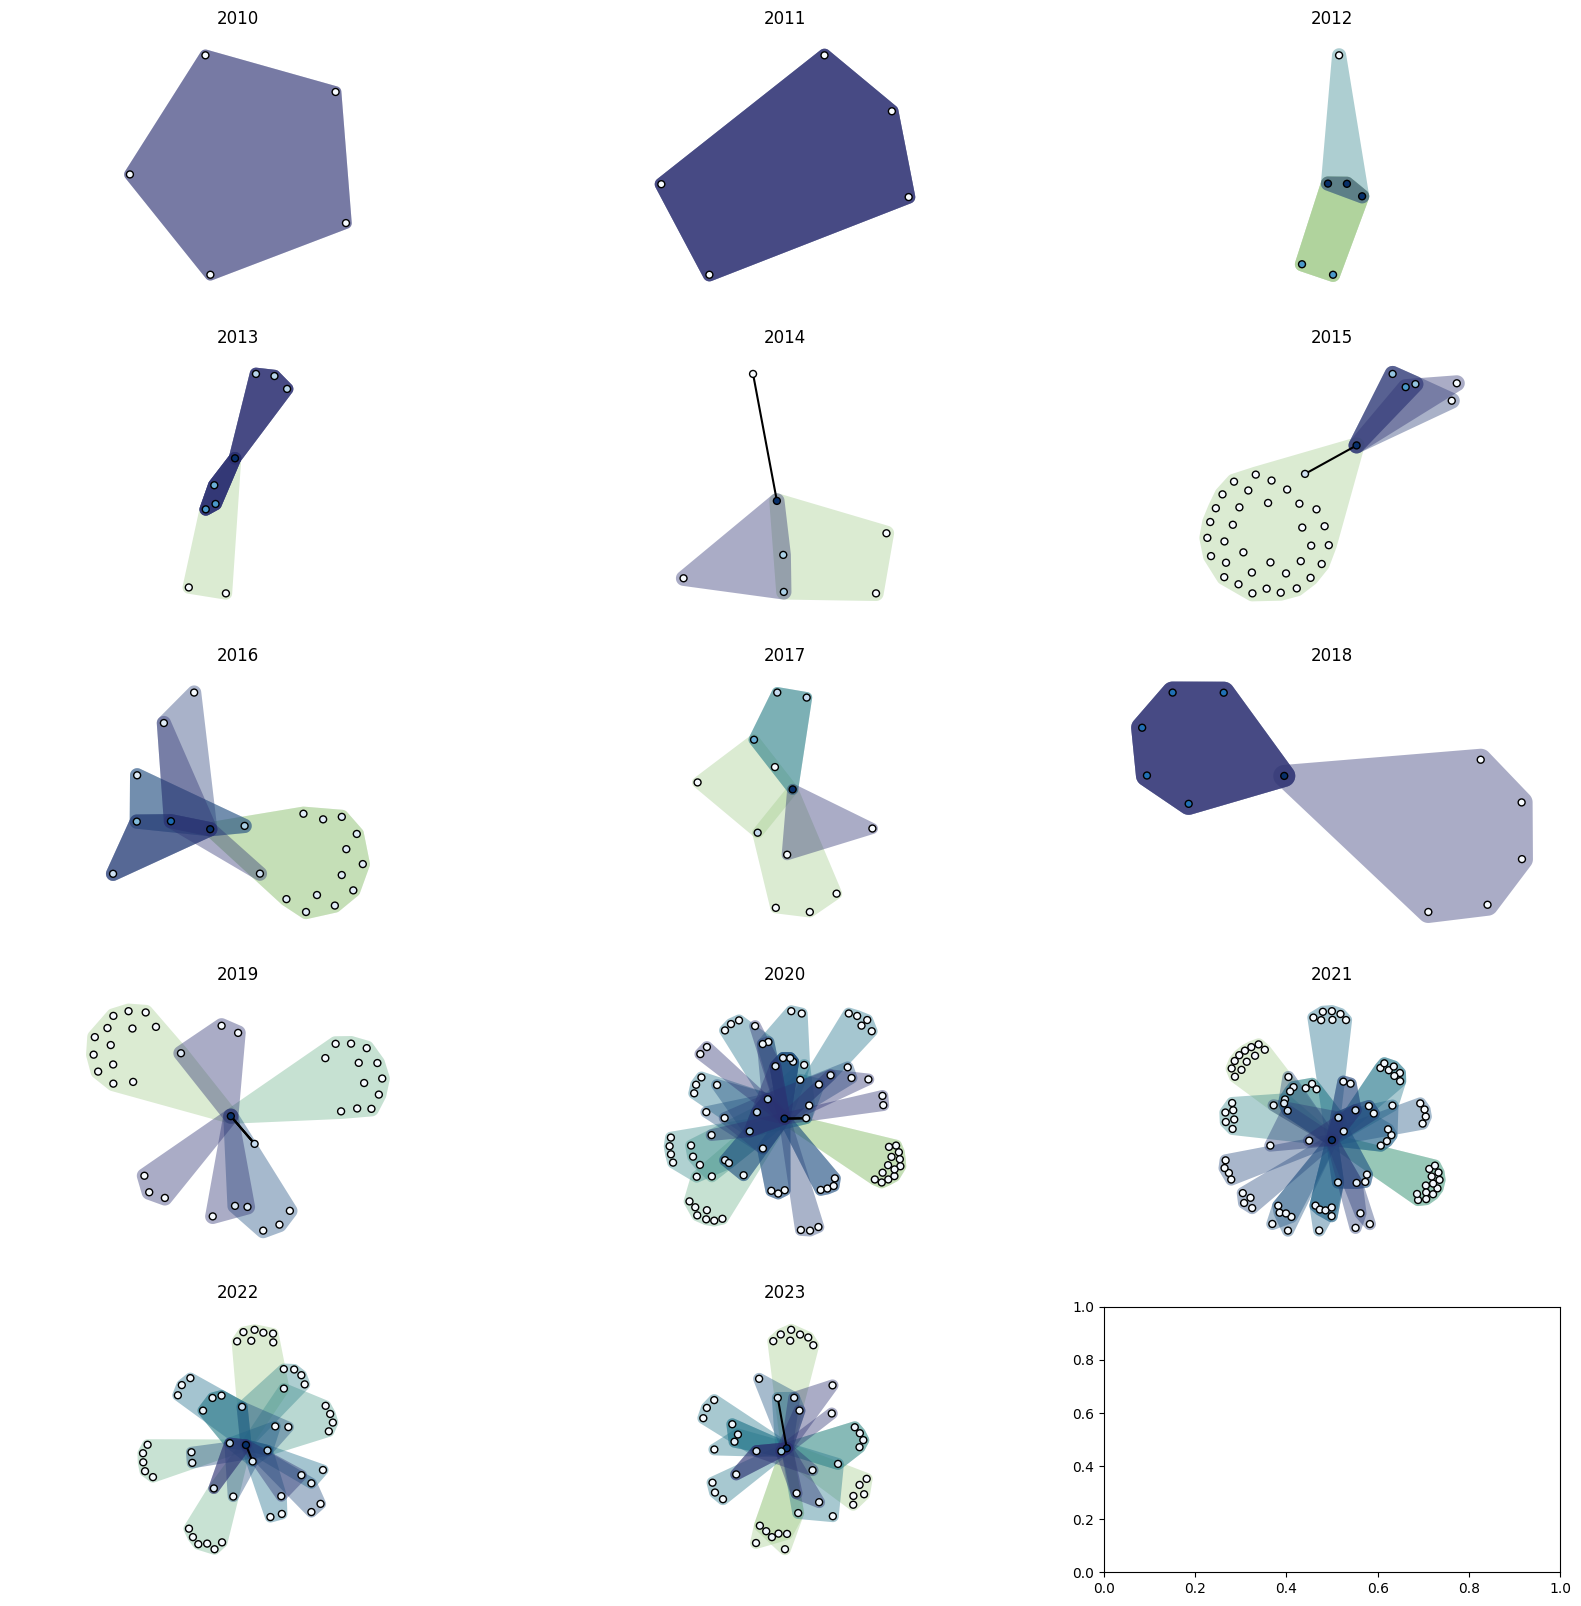

In [70]:
yr_window = 1
tot_yrs = list(range(0, len(PI_fnames)+1, yr_window))
tot_frames = len(tot_yrs)
nb_rows = tot_frames // 3
height_d = { 1:20, 2:15, 3:10 }
fig, axes = plt.subplots(nb_rows, 3, figsize=(20,height_d[yr_window]))
for idx, ax in zip(tot_yrs, axes.flatten()):
    
    hyperedge_list = []
    
    for i,fname in enumerate(PI_fnames[idx:(idx+yr_window)]):
        works = read_jsonl(fname)
        if i == 0:
            first_yr=fname.stem.split('_')[-1]
        last_yr=fname.stem.split('_')[-1]
    
        hyperedge_list += [extract_coauthor(w) for w in works]
    
    H = xgi.Hypergraph()
    H.add_edges_from(hyperedge_list)
    
    if len(H.nodes) > 0:
        pos = xgi.barycenter_spring_layout(H, seed=42)  # fix position
        max_key = max(H.nodes.degree().asdict(), key=H.nodes.degree().asdict().get)
        _, collections = xgi.draw(H, ax=ax, pos=pos, node_size=5, node_labels=False if max_key else True, 
                                  node_fc=H.nodes.degree(), node_fc_cmap="Blues", hull=True)
        (node_collection, _, _) = collections

        ax.set_title(f"{first_yr}-{last_yr}") if yr_window > 1 else ax.set_title(f"{first_yr}")
        # print(f"{len(hyperedge_list)} papers are shown")
        # print(f"Highest degree {first_yr}-{last_yr}: {max_key}") # highest degree node 

In [71]:
# OVERVIEW OF HYPEREDGES CONSIDERED AS LOCAL WORK

yr_window = 1
tot_yrs = list(range(0, len(PI_fnames)+1, yr_window))
all_edgelist = []
for idx in tot_yrs:
    
    hyperedge_list_meta = []
    nodelist = []
    
    for i,fname in enumerate(PI_fnames[idx:(idx+yr_window)]):
        works = read_jsonl(fname)
        if i == 0:
            first_yr=fname.stem.split('_')[-1]
        last_yr=fname.stem.split('_')[-1]
    
        hyperedge_list = [extract_coauthor(w) for w in works]
    
        time_collabo = extract_coauthor_inst(works)
        node_meta_dict = extract_main_inst(time_collabo, target_name)
        for e in hyperedge_list:
            hyperedge_list_meta.append((e, {'local_work':True if sum([node_meta_dict[a]['is_shared'] for a in e]) > 1 else False}))
    
        set_individuals_involved_local_work = set(flatten([_[0] for _ in hyperedge_list_meta if _[1]['local_work']]))
        
        for i,auth in enumerate(node_meta_dict.keys()):
            nodelist.append((auth, {
                'institution': node_meta_dict[auth]['institution'], 
                'is_shared': node_meta_dict[auth]['is_shared'],
                'involve_local_work': True if auth in set_individuals_involved_local_work  else False
                }))
            
    all_edgelist.append((first_yr, last_yr, hyperedge_list_meta, nodelist))

In [72]:
len(all_edgelist)

15

In [73]:
local_nodes=set(flatten([flatten([_[0] for _ in e[2]]) for e in all_edgelist]))

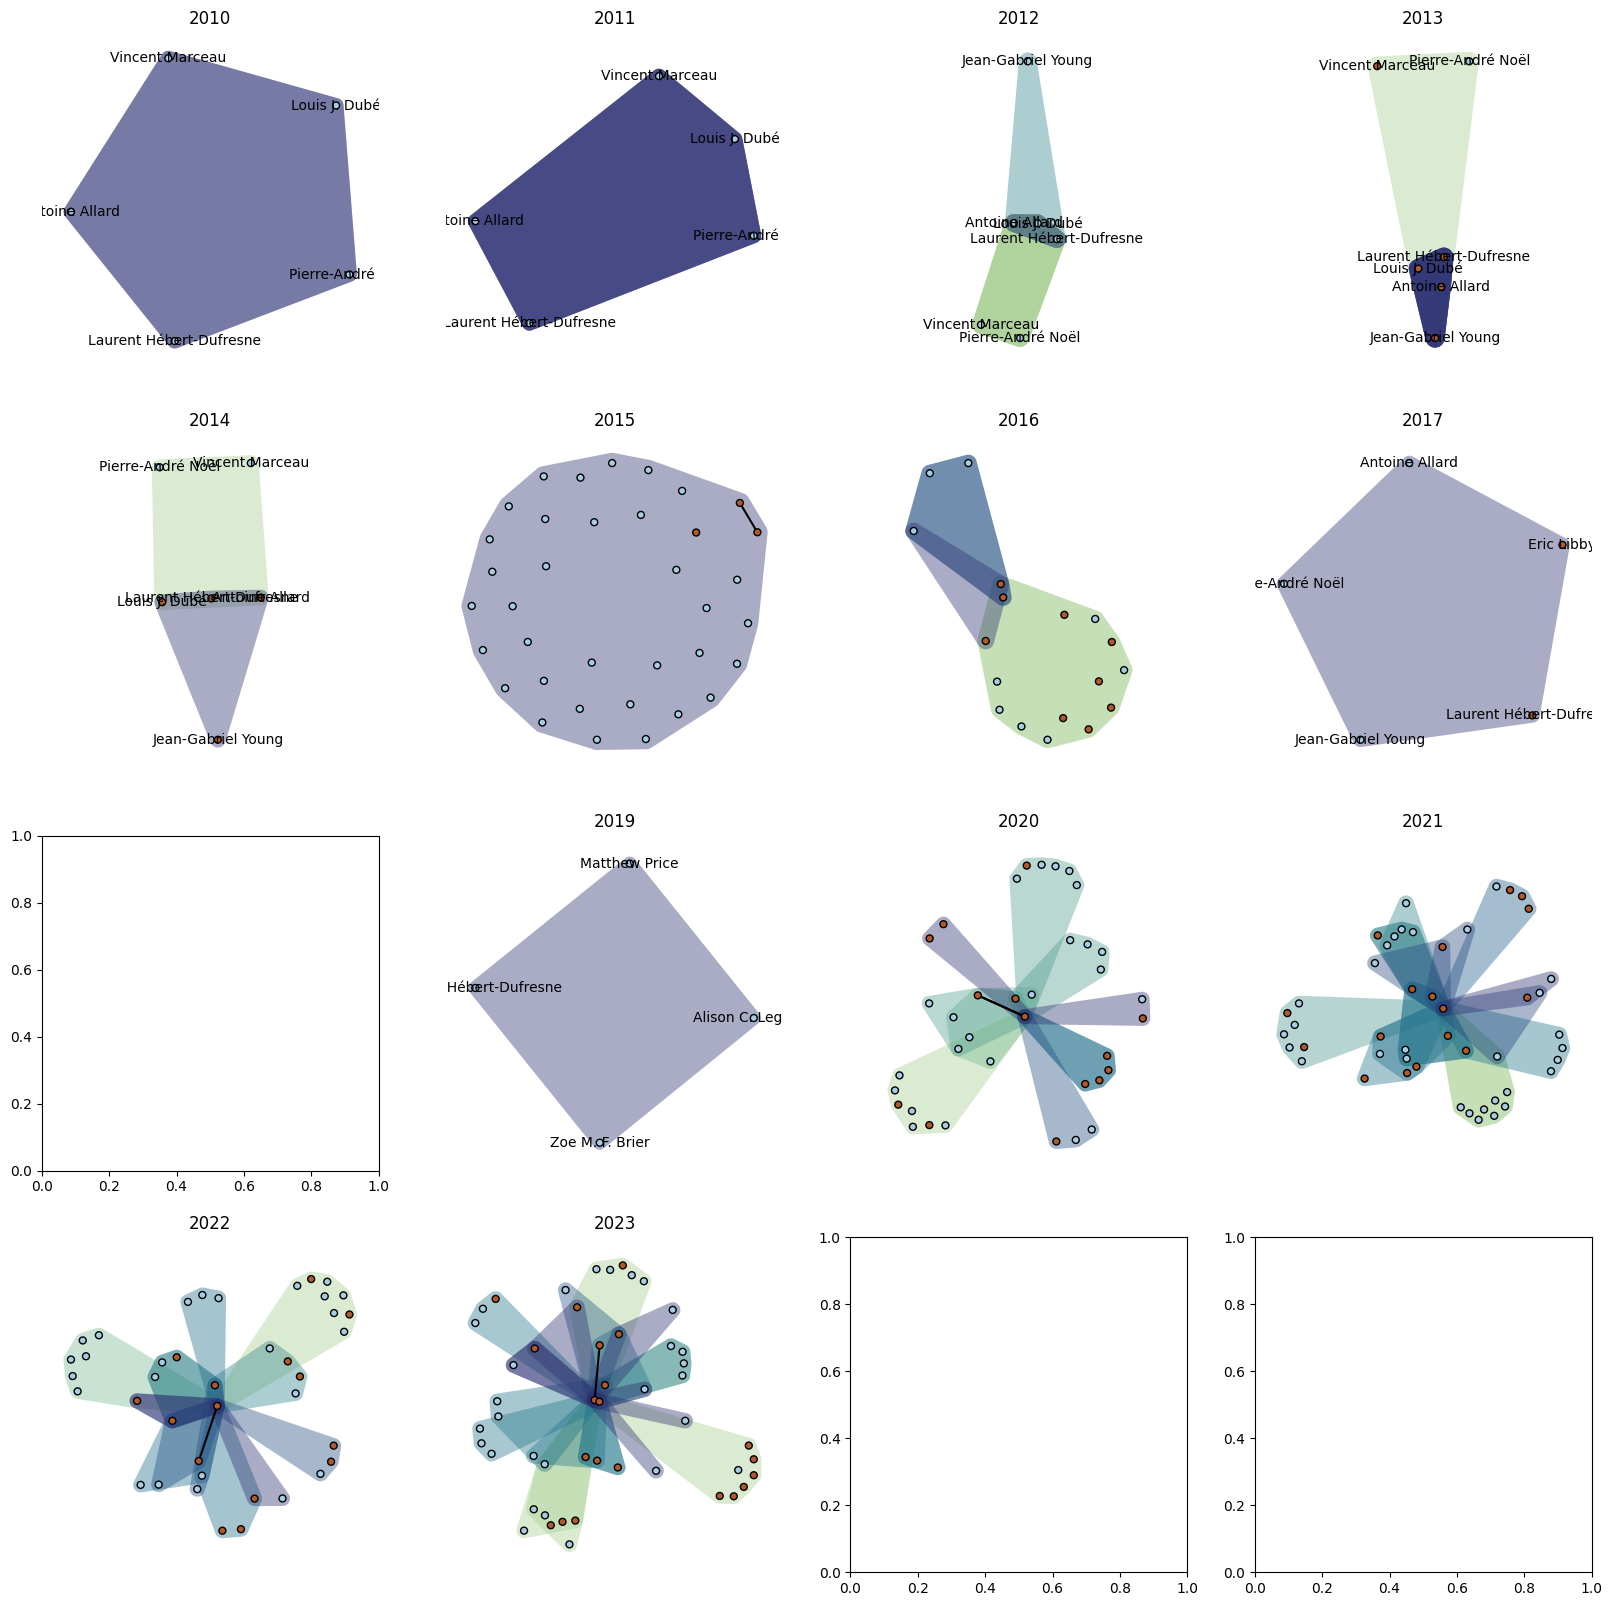

In [74]:
# OVERVIEW OF HYPEREDGES CONSIDERED AS LOCAL WORK
all_local_nodes = []
fig, axes = plt.subplots(4, 4, figsize=(20,20))
for i, (ax, dat) in enumerate(zip(axes.flatten(), all_edgelist)):
    
    if i >= len(all_edgelist):
        break
    
    first_yr, last_yr, edgelist, nodelist = dat


    H = xgi.Hypergraph()
    H.add_nodes_from(nodelist)
    H.add_edges_from(edgelist)

    all_local_nodes += H.nodes.filterby_attr("involve_local_work", True)

    H_f = xgi.subhypergraph(H, 
        nodes=H.nodes.filterby_attr("involve_local_work", True),
        edges=H.edges.filterby_attr("local_work", True)
    )


    if len(H_f.nodes) > 0:    
        
        pos = xgi.barycenter_spring_layout(H_f, seed=42)  # fix position
        max_key = max(H_f.nodes.degree().asdict(), key=H_f.nodes.degree().asdict().get)
        _, collections = xgi.draw(
            H_f, pos=pos, ax=ax, node_size=5,
            node_labels=True if len(H_f.nodes) < 12 else False,
            node_fc=H_f.nodes.attrs("is_shared").aslist(), 
            node_fc_cmap="Paired", 
            hull=True
            )
        (node_collection, _, _) = collections
        ax.set_title(f"{first_yr}-{last_yr}") if yr_window > 1 else ax.set_title(f"{first_yr}")

# plt.savefig(f"{target_name.replace(' ', '_')}_local_work.pdf")

In [75]:
all_local_nodes = list(set(all_local_nodes))

In [76]:
from timeline import get_author_data

In [83]:
all_local_nodes[4]

'Charles J. Murphy'

In [84]:
name2aid[all_local_nodes[4]]

'A5067525240'

In [80]:
get_author_data(name2aid[all_local_nodes[2]])

100%|██████████| 74/74 [07:44<00:00,  6.28s/it]
